In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA

# Load the dataset
file_path = 'house-prices-advanced-regression-techniques/train.csv'
df = pd.read_csv(file_path)

# Calculate the threshold based on 50% of the number of rows
threshold = len(df) * 0.5

# Drop columns where more than 50% of values are NaN
df = df.dropna(axis=1, thresh=threshold)
df = df.dropna()

# Assuming you have your data loaded into a pandas DataFrame called 'df'
categorical_columns = []
for column in df.columns:
    if df[column].dtype == 'object':
        categorical_columns.append(column)

# Apply One-Hot Encoding to nominal categorical columns
df_enc = pd.get_dummies(df, columns=categorical_columns)

scaler = StandardScaler()
df_enc_scaled = pd.DataFrame(scaler.fit_transform(df_enc), columns=df_enc.columns)

y = df_enc_scaled['SalePrice']
X = df_enc_scaled.drop(['Id', 'SalePrice'], axis=1)

# Perform PCA
num_components = 10
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X)

# Initialize results table
results = []

# Train neural networks with varying depths on subsets of PCA components
depths = [5, 10, 15]
subsets = [X_pca[:, :i] for i in range(1, num_components + 1)]

# Create a directory to save plots if it doesn't exist
plot_dir = 'Regression_PCA'
os.makedirs(plot_dir, exist_ok=True)

for subset in subsets:
    for depth in depths:
        model = Sequential()
        model.add(Dense(units=depth, activation='relu', input_dim=subset.shape[1]))
        for _ in range(depth - 1):
            model.add(Dense(units=depth, activation='relu'))
        model.add(Dense(units=1, activation='linear'))

        model.compile(loss='mean_squared_error', optimizer='adam')

        X_train, X_test, y_train, y_test = train_test_split(subset, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, 
                            validation_data=(X_val, y_val),
                            callbacks=[EarlyStopping(patience=100)])

        loss = model.evaluate(X_test, y_test, verbose=0)
        
        # Append results to the table
        results.append({'Depth': depth, 'Subset Size': subset.shape[1], 'Test MSE': loss})

        # Plot training and validation loss
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Subset size: {subset.shape[1]}, Depth: {depth}, Test loss: {loss:.4f}')
        plt.legend()
        plt.savefig(os.path.join(plot_dir, f'loss_plot_subset_{subset.shape[1]}_depth_{depth}_regression_PCA.png'))
        plt.close()

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Save the results table to a CSV file
results_df.to_csv('results_table.csv', index=False)


In [2]:
results_df

,Depth,Subset Size,Test MSE
0,5,1,0.349591
1,10,1,0.325577
2,15,1,0.393100
3,5,2,0.352492
4,10,2,0.342992
5,15,2,0.384185
6,5,3,0.175580
7,10,3,0.173224
8,15,3,0.262930
9,5,4,0.126603


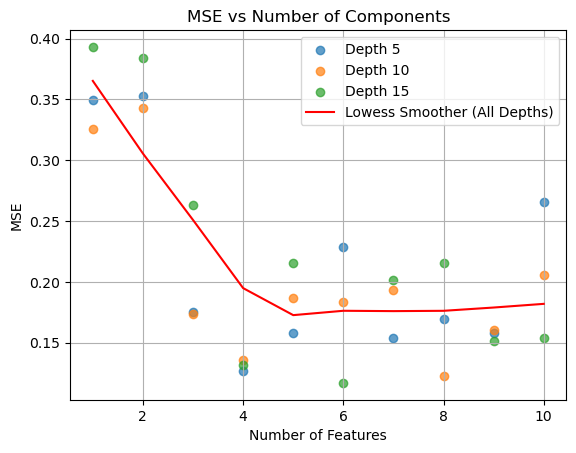

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr


# Create the scatter plot
plt.figure()

depths = results_df['Depth'].unique()

# Plot scatter plot for each depth with its own color
for depth in depths:
    subset_df = results_df[results_df['Depth'] == depth]
    plt.scatter(subset_df['Subset Size'], subset_df['Test MSE'], label=f'Depth {depth}', alpha=0.7)

plt.xlabel('Number of Features')
plt.ylabel('MSE')
plt.title('MSE vs Number of Components')
plt.grid(True)

# Compute the lowess smoother for the entire dataset
lowess = sm.nonparametric.lowess(results_df['Test MSE'], results_df['Subset Size'])
lowess_x, lowess_y = lowess.T

# Plot the lowess smoother for the entire dataset
plt.plot(lowess_x, lowess_y, color='red', label='Lowess Smoother (All Depths)')

# Calculate Pearson correlation coefficient and p-value for the entire dataset
#pearson_corr, p_value = pearsonr(results_df['Subset Size'], results_df['Test MSE'])
#print(f"Pearson Correlation Coefficient: {pearson_corr}")
#print(f"P-value: {p_value}")

plt.legend()
plt.savefig('regressions PCA smoother all.png')
plt.show()


In [5]:
# Calculate Pearson correlation coefficient and p-value for the entire dataset
pearson_corr, p_value = pearsonr(results_df['Subset Size'], results_df['Test MSE'])
print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: -0.5943480189993948
P-value: 0.0005336566246315636


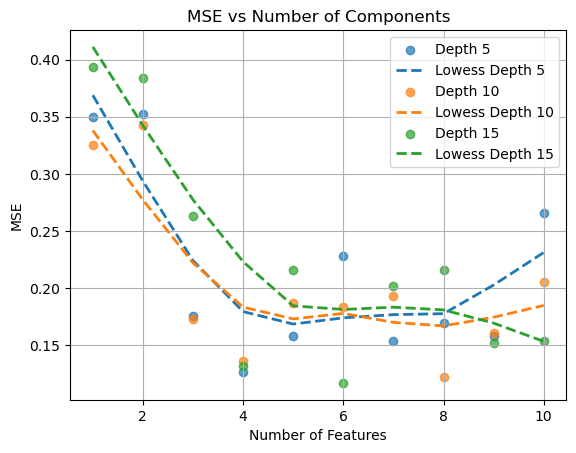

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr


# Create the scatter plot
plt.figure()

depths = results_df['Depth'].unique()

# Plot scatter plot and LOWESS smoother for each depth with its own color
for depth in depths:
    subset_df = results_df[results_df['Depth'] == depth]
    plt.scatter(subset_df['Subset Size'], subset_df['Test MSE'], label=f'Depth {depth}', alpha=0.7)
    
    # Compute the LOWESS smoother for each depth
    lowess_depth = sm.nonparametric.lowess(subset_df['Test MSE'], subset_df['Subset Size'])
    lowess_depth_x, lowess_depth_y = lowess_depth.T
    
    # Plot the LOWESS smoother for each depth
    plt.plot(lowess_depth_x, lowess_depth_y, label=f'Lowess Depth {depth}', linestyle='--', linewidth=2)

plt.xlabel('Number of Features')
plt.ylabel('MSE')
plt.title('MSE vs Number of Components')
plt.grid(True)

# Compute the overall LOWESS smoother for the entire dataset
lowess = sm.nonparametric.lowess(results_df['Test MSE'], results_df['Subset Size'])
lowess_x, lowess_y = lowess.T

# Plot the overall LOWESS smoother
#plt.plot(lowess_x, lowess_y, color='red', label='Lowess Smoother (All Depths)')

# Calculate Pearson correlation coefficient and p-value for the entire dataset
#pearson_corr, p_value = pearsonr(results_df['Subset Size'], results_df['Test MSE'])
#print(f"Pearson Correlation Coefficient: {pearson_corr}")
#print(f"P-value: {p_value}")

plt.legend()
plt.savefig('regression PCA split.png')
plt.show()
